<h1 class="font-effect-fire-animation" style="color:crimson; font-family:Akronim;">Code Modules, Styling, Helpful Functions and Links</h1>
#### [Github Version](https://github.com/OlgaBelitskaya/deep_learning_projects/blob/master/DL_PP4) & [Colaboratory Version](https://colab.research.google.com/drive/1r5yRD-3tQwN6lSql_VRoVuwQ8DaY5zUt)

In [1]:
%%html
<style> 
@import url('https://fonts.googleapis.com/css?family=Akronim|Roboto&effect=fire-animation');
span {color:black; text-shadow:4px 4px 4px #aaa;}
div.output_prompt {color:crimson;} 
div.input_prompt {color:firebrick;} 
div.output_area pre,div.output_subarea {font-size:15px; color:crimson}
div.output_stderr pre {background-color:#f7e8e8;}
</style>

In [2]:
import warnings; warnings.filterwarnings('ignore')
import h5py,os,pandas as pd,numpy as np,pylab as pl
import seaborn as sn,keras as ks,tensorflow as tf
from skimage.transform import resize
import scipy; from scipy import misc
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
np.set_printoptions(precision=6)
pl.style.use('seaborn-whitegrid')
fw='weights.style.hdf5'
from keras.callbacks import ModelCheckpoint,EarlyStopping
from keras.callbacks import ReduceLROnPlateau
from keras.models import Sequential,load_model,Model
from keras.layers import Input,Activation,Dense,LSTM
from keras.layers import Flatten,Dropout,BatchNormalization
from keras.layers import Conv2D,MaxPooling2D
from keras.layers import GlobalAveragePooling2D,GlobalMaxPooling2D
from keras.layers.advanced_activations import PReLU,LeakyReLU
from keras.applications.resnet50 import ResNet50
from keras.applications.resnet50 import preprocess_input as resnet50pi
from keras.applications.inception_v3 import InceptionV3
from keras.applications.inception_v3 import preprocess_input as inceptionv3pi
from keras.applications.xception import Xception
from keras.applications.xception import preprocess_input as xceptionpi
from keras.applications.inception_resnet_v2 import InceptionResNetV2
from keras.applications.inception_resnet_v2 import preprocess_input as inceptionresnetv2pi
from keras import __version__
print('keras version:', __version__)
print('tensorflow version:',tf.__version__)
print(os.listdir("../input"))

Using TensorFlow backend.


keras version: 2.1.5
tensorflow version: 1.7.0
['xception', 'inceptionresnetv2', 'style-color-images', 'resnet50', 'inceptionv3']


In [3]:
def ohe(x): 
    return OneHotEncoder(n_values='auto')\
           .fit(x.reshape(-1,1)).transform(x.reshape(-1,1))\
           .toarray().astype('int64')
def tts(X,y): 
    x_train,x_test,y_train,y_test=\
    train_test_split(X,y,test_size=.2,random_state=1)
    n=int(len(x_test)/2)
    x_valid,y_valid=x_test[:n],y_test[:n]
    x_test,y_test=x_test[n:],y_test[n:]
    return x_train,x_valid,x_test,y_train,y_valid,y_test
def history_plot(fit_history):
    pl.figure(figsize=(12,10)); pl.subplot(211)
    keys=list(fit_history.history.keys())[0:4]
    pl.plot(fit_history.history[keys[0]],
            color='crimson',label='train')
    pl.plot(fit_history.history[keys[2]],
            color='firebrick',label='valid')
    pl.xlabel("Epochs"); pl.ylabel("Loss")
    pl.legend(); pl.grid()
    pl.title('Loss Function')     
    pl.subplot(212)
    pl.plot(fit_history.history[keys[1]],
            color='crimson',label='train')
    pl.plot(fit_history.history[keys[3]],
            color='firebrick',label='valid')
    pl.xlabel("Epochs"); pl.ylabel("Accuracy")    
    pl.legend(); pl.grid()
    pl.title('Accuracy'); pl.show()

<h1 class="font-effect-fire-animation" style="color:crimson; font-family:Akronim;">Data Preprocessing</h1>

In [4]:
data=pd.read_csv("../input/style-color-images/style/style.csv")
data.tail()

,brand_name,brand_label,product_name,product_label,file
2179,Yves Saint Laurent,6,earrings,9,6_9_017.png
2180,Yves Saint Laurent,6,earrings,9,6_9_018.png
2181,Yves Saint Laurent,6,earrings,9,6_9_019.png
2182,Yves Saint Laurent,6,earrings,9,6_9_020.png
2183,Yves Saint Laurent,6,earrings,9,6_9_021.png


In [5]:
f=h5py.File('../input/style-color-images/StyleColorImages.h5','r')
keys=list(f.keys())
brands=np.array(f[keys[0]])
images=np.array(f[keys[1]])
products=np.array(f[keys[2]])
[keys,[brands.shape,images.shape,products.shape]]

[['brands', 'images', 'products'], [(2184,), (2184, 150, 150, 3), (2184,)]]

Product:  lipstick
Brand:  Christian Louboutin


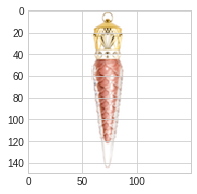

In [6]:
# normalization of image arrays
images=images.astype('float32')/255
print('Product: ',data['product_name'][100])
print('Brand: ',data['brand_name'][100])
pl.figure(figsize=(3,3)); pl.imshow(images[100])
pl.show()

In [7]:
# one-hot encoding
cbrands,cproducts=ohe(brands),ohe(products)
ctargets=np.concatenate((cbrands,cproducts),axis=1)
pd.DataFrame([images.shape,cbrands.shape,
              cproducts.shape,ctargets.shape])

,0,1,2,3
0,2184,150,150.0,3.0
1,2184,7,NaN,NaN
2,2184,10,NaN,NaN
3,2184,17,NaN,NaN


In [8]:
# splitting the data
# Color Images / Brands 
x_train1,x_valid1,x_test1,\
y_train1,y_valid1,y_test1=tts(images,cbrands)
# Color Images / Products 
x_train3,x_valid3,x_test3,\
y_train3,y_valid3,y_test3=tts(images,cproducts)

<h1 class="font-effect-fire-animation" style="color:crimson; font-family:Akronim;">Classification Models</h1>
## ResNet50

In [9]:
# creating bottleneck features
resize_x_train=np.array([scipy.misc.imresize(x_train1[i],(197,197,3)) 
                           for i in range(0,len(x_train1))]).astype('float32')
resize_x_valid=np.array([scipy.misc.imresize(x_valid1[i],(197,197,3)) 
                           for i in range(0,len(x_valid1))]).astype('float32')
resize_x_test=np.array([scipy.misc.imresize(x_test1[i],(197,197,3)) 
                         for i in range(0,len(x_test1))]).astype('float32')
x_train_bn=resnet50pi(resize_x_train)
x_valid_bn =resnet50pi(resize_x_valid)
x_test_bn=resnet50pi(resize_x_test)
fn='../input/resnet50/resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5'
resnet50_base_model=ResNet50(weights=fn,include_top=False)
x_train_bn=resnet50_base_model.predict(x_train_bn)
x_valid_bn=resnet50_base_model.predict(x_valid_bn)
x_test_bn=resnet50_base_model.predict(x_test_bn)

In [10]:
sh=x_train_bn.shape[1:]
def resnet50_model():
    model=Sequential()   
    model.add(GlobalAveragePooling2D(input_shape=sh))    
    model.add(Dense(2048))
    model.add(LeakyReLU(alpha=.02))
    model.add(Dropout(.5))        
    model.add(Dense(512))
    model.add(LeakyReLU(alpha=.02))
    model.add(Dropout(.5))
    model.add(Dense(7,activation='softmax'))    
    model.compile(loss='categorical_crossentropy',
                  optimizer='adam',metrics=['accuracy'])
    return model
resnet50_model=resnet50_model()

In [11]:
checkpointer=ModelCheckpoint(filepath=fw,verbose=2,save_best_only=True)
lr_reduction=ReduceLROnPlateau(monitor='val_loss',patience=10,
                               verbose=2,factor=.5)
estopping=EarlyStopping(monitor='val_loss',patience=25,verbose=2)
history=\
resnet50_model.fit(x_train_bn,y_train1,
                   validation_data=(x_valid_bn,y_valid1),
                   epochs=100,batch_size=128,verbose=2,
                   callbacks=[checkpointer,lr_reduction,estopping]);

Train on 1747 samples, validate on 218 samples
Epoch 1/100
 - 3s - loss: 2.2626 - acc: 0.2759 - val_loss: 1.5140 - val_acc: 0.4450

Epoch 00001: val_loss improved from inf to 1.51401, saving model to weights.style.hdf5
Epoch 2/100
 - 1s - loss: 1.5113 - acc: 0.4070 - val_loss: 1.2639 - val_acc: 0.5596

Epoch 00002: val_loss improved from 1.51401 to 1.26393, saving model to weights.style.hdf5
Epoch 3/100
 - 1s - loss: 1.2329 - acc: 0.5501 - val_loss: 1.0892 - val_acc: 0.6284

Epoch 00003: val_loss improved from 1.26393 to 1.08918, saving model to weights.style.hdf5
Epoch 4/100
 - 1s - loss: 1.0334 - acc: 0.6245 - val_loss: 0.9915 - val_acc: 0.6422

Epoch 00004: val_loss improved from 1.08918 to 0.99146, saving model to weights.style.hdf5
Epoch 5/100
 - 1s - loss: 0.8828 - acc: 0.6875 - val_loss: 0.9199 - val_acc: 0.6651

Epoch 00005: val_loss improved from 0.99146 to 0.91994, saving model to weights.style.hdf5
Epoch 6/100
 - 1s - loss: 0.7238 - acc: 0.7390 - val_loss: 0.8540 - val_acc: 

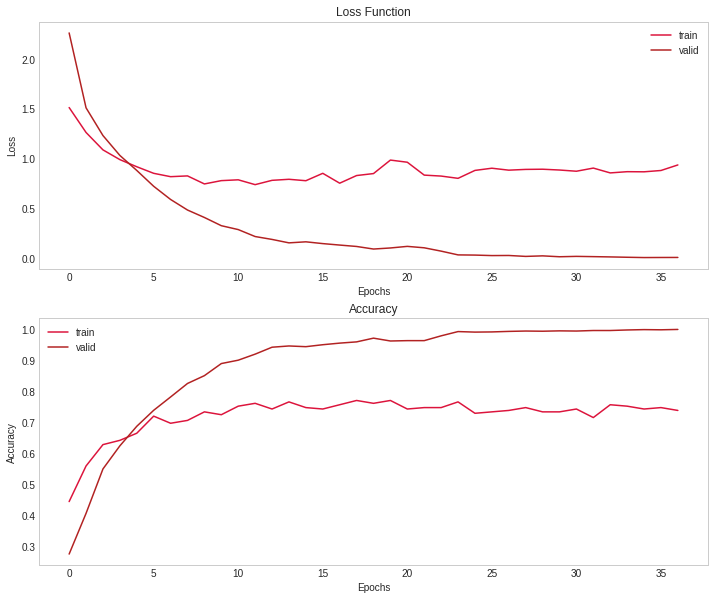

219/219 [==============================] - 0s 287us/step
Accuracy: 73.52%


[0.7921069876788414, 0.7351598143577576]

In [12]:
history_plot(history)
resnet50_model.load_weights(fw)
resnet50_scores=resnet50_model.evaluate(x_test_bn,y_test1)
print("Accuracy: %.2f%%"%(resnet50_scores[1]*100))
resnet50_scores

## Inception V3

In [13]:
resize_x_train=np.array([scipy.misc.imresize(x_train3[i],(139,139,3)) 
                         for i in range(0,len(x_train3))]).astype('float32')
resize_x_valid=np.array([scipy.misc.imresize(x_valid3[i],(139,139,3)) 
                         for i in range(0,len(x_valid3))]).astype('float32')
resize_x_test=np.array([scipy.misc.imresize(x_test3[i],(139,139,3)) 
                        for i in range(0,len(x_test3))]).astype('float32')
x_train_bn=inceptionv3pi(resize_x_train)
x_valid_bn=inceptionv3pi(resize_x_valid)
x_test_bn=inceptionv3pi(resize_x_test)
fn='../input/inceptionv3/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5'
inception_v3_base_model=InceptionV3(weights=fn,include_top=False)
x_train_bn=inception_v3_base_model.predict(x_train_bn)
x_valid_bn=inception_v3_base_model.predict(x_valid_bn)
x_test_bn=inception_v3_base_model.predict(x_test_bn)

In [14]:
sh=x_train_bn.shape[1:]
def inception_v3_model():
    model=Sequential()  
    model.add(GlobalAveragePooling2D(input_shape=sh))    
    model.add(Dense(2048))
    model.add(LeakyReLU(alpha=.02))
    model.add(Dropout(.5))       
    model.add(Dense(512))
    model.add(LeakyReLU(alpha=.02))
    model.add(Dropout(.5))
    model.add(Dense(10,activation='softmax'))     
    model.compile(loss='categorical_crossentropy',
                  optimizer='nadam',metrics=['accuracy'])
    return model
inception_v3_model=inception_v3_model()

In [15]:
checkpointer=ModelCheckpoint(filepath=fw,verbose=2,save_best_only=True)
lr_reduction=ReduceLROnPlateau(monitor='val_loss',patience=10,
                               verbose=2,factor=.5)
estopping=EarlyStopping(monitor='val_loss',patience=25,verbose=2)
history=\
inception_v3_model.fit(x_train_bn,y_train3,
                       validation_data=(x_valid_bn,y_valid3),
                       epochs=100,batch_size=128,verbose=2,
                       callbacks=[checkpointer,lr_reduction,estopping]);

Train on 1747 samples, validate on 218 samples
Epoch 1/100
 - 4s - loss: 8.1366 - acc: 0.2398 - val_loss: 1.8462 - val_acc: 0.4220

Epoch 00001: val_loss improved from inf to 1.84622, saving model to weights.style.hdf5
Epoch 2/100
 - 2s - loss: 1.4443 - acc: 0.5867 - val_loss: 0.9997 - val_acc: 0.6606

Epoch 00002: val_loss improved from 1.84622 to 0.99968, saving model to weights.style.hdf5
Epoch 3/100
 - 2s - loss: 0.8480 - acc: 0.7338 - val_loss: 0.9213 - val_acc: 0.7156

Epoch 00003: val_loss improved from 0.99968 to 0.92132, saving model to weights.style.hdf5
Epoch 4/100
 - 2s - loss: 0.6446 - acc: 0.7951 - val_loss: 0.7207 - val_acc: 0.7569

Epoch 00004: val_loss improved from 0.92132 to 0.72072, saving model to weights.style.hdf5
Epoch 5/100
 - 2s - loss: 0.6248 - acc: 0.7916 - val_loss: 0.7632 - val_acc: 0.7752

Epoch 00005: val_loss did not improve
Epoch 6/100
 - 2s - loss: 0.4437 - acc: 0.8517 - val_loss: 0.7212 - val_acc: 0.7890

Epoch 00006: val_loss did not improve
Epoch 7

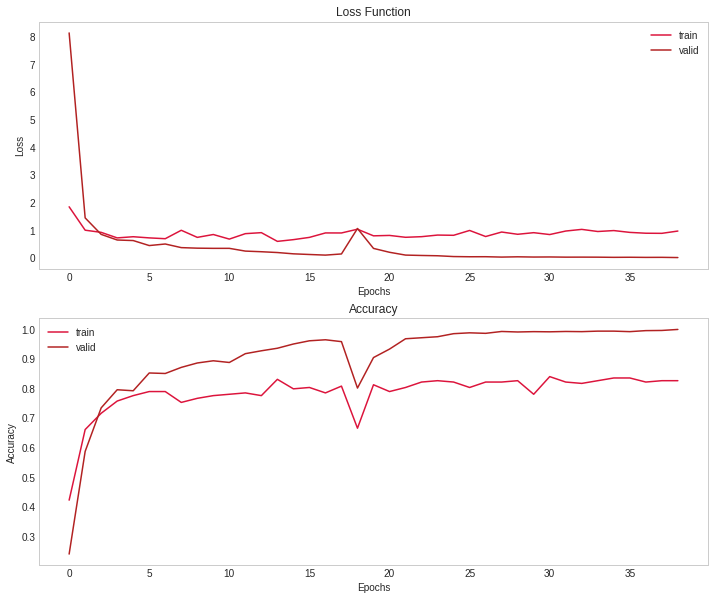

219/219 [==============================] - 0s 345us/step
Accuracy: 80.82%


[0.5609007804361108, 0.8082191769935224]

In [16]:
history_plot(history)
inception_v3_model.load_weights(fw)
inception_v3_scores=inception_v3_model.evaluate(x_test_bn,y_test3)
print("Accuracy: %.2f%%"%(inception_v3_scores[1]*100))
inception_v3_scores

## Xception

In [17]:
resize_x_train=np.array([scipy.misc.imresize(x_train1[i],(71,71,3)) 
                         for i in range(0,len(x_train1))]).astype('float32')
resize_x_valid=np.array([scipy.misc.imresize(x_valid1[i],(71,71,3)) 
                         for i in range(0,len(x_valid1))]).astype('float32')
resize_x_test=np.array([scipy.misc.imresize(x_test1[i],(71,71,3)) 
                        for i in range(0,len(x_test1))]).astype('float32')
x_train_bn=xceptionpi(resize_x_train)
x_valid_bn=xceptionpi(resize_x_valid)
x_test_bn=xceptionpi(resize_x_test)
fn='../input/xception/xception_weights_tf_dim_ordering_tf_kernels_notop.h5'
xception_base_model=Xception(weights=fn,include_top=False)
x_train_bn=xception_base_model.predict(x_train_bn)
x_valid_bn=xception_base_model.predict(x_valid_bn)
x_test_bn=xception_base_model.predict(x_test_bn)

In [18]:
sh=x_train_bn.shape[1:]
def xception_model():
    model=Sequential()   
    model.add(GlobalAveragePooling2D(input_shape=sh))    
    model.add(Dense(2048))
    model.add(LeakyReLU(alpha=.02))
    model.add(Dropout(.5))        
    model.add(Dense(256))
    model.add(LeakyReLU(alpha=.02))
    model.add(Dropout(.5))
    model.add(Dense(7,activation='softmax'))   
    model.compile(loss='categorical_crossentropy',
                  optimizer='adam',metrics=['accuracy'])
    return model
xception_model=xception_model()

In [19]:
checkpointer=ModelCheckpoint(filepath=fw,verbose=2,save_best_only=True)
lr_reduction=ReduceLROnPlateau(monitor='val_loss',patience=10,
                               verbose=2,factor=.5)
estopping=EarlyStopping(monitor='val_loss',patience=25,verbose=2)
history=\
xception_model.fit(x_train_bn,y_train1,
                   validation_data=(x_valid_bn,y_valid1),
                   epochs=100,batch_size=128,verbose=2,
                   callbacks=[checkpointer,lr_reduction,estopping]);

Train on 1747 samples, validate on 218 samples
Epoch 1/100
 - 4s - loss: 2.0316 - acc: 0.2433 - val_loss: 1.6953 - val_acc: 0.3211

Epoch 00001: val_loss improved from inf to 1.69525, saving model to weights.style.hdf5
Epoch 2/100
 - 1s - loss: 1.6444 - acc: 0.3732 - val_loss: 1.5346 - val_acc: 0.3991

Epoch 00002: val_loss improved from 1.69525 to 1.53460, saving model to weights.style.hdf5
Epoch 3/100
 - 1s - loss: 1.4821 - acc: 0.4448 - val_loss: 1.4388 - val_acc: 0.4908

Epoch 00003: val_loss improved from 1.53460 to 1.43878, saving model to weights.style.hdf5
Epoch 4/100
 - 1s - loss: 1.3455 - acc: 0.5083 - val_loss: 1.3497 - val_acc: 0.4954

Epoch 00004: val_loss improved from 1.43878 to 1.34966, saving model to weights.style.hdf5
Epoch 5/100
 - 1s - loss: 1.2125 - acc: 0.5570 - val_loss: 1.2707 - val_acc: 0.5275

Epoch 00005: val_loss improved from 1.34966 to 1.27072, saving model to weights.style.hdf5
Epoch 6/100
 - 1s - loss: 1.0812 - acc: 0.6090 - val_loss: 1.2945 - val_acc: 

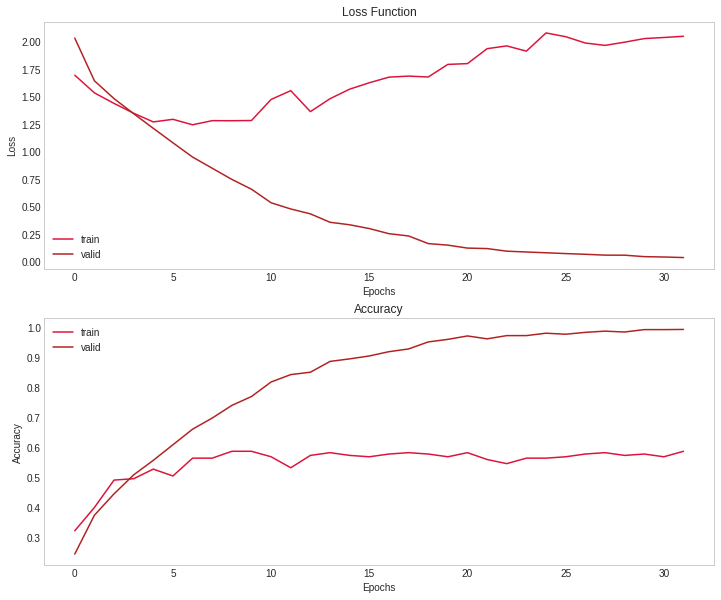

219/219 [==============================] - 0s 854us/step
Accuracy: 50.23%


[1.4555834814838078, 0.502283107472337]

In [20]:
history_plot(history)
xception_model.load_weights(fw)
xception_scores=xception_model.evaluate(x_test_bn,y_test1)
print("Accuracy: %.2f%%"%(xception_scores[1]*100))
xception_scores

## InceptionResNetV2

In [21]:
resize_x_train=np.array([scipy.misc.imresize(x_train3[i],(139,139,3)) 
                         for i in range(0,len(x_train3))]).astype('float32')
resize_x_valid=np.array([scipy.misc.imresize(x_valid3[i],(139,139,3)) 
                         for i in range(0,len(x_valid3))]).astype('float32')
resize_x_test=np.array([scipy.misc.imresize(x_test3[i],(139,139,3)) 
                        for i in range(0,len(x_test3))]).astype('float32')
x_train_bn=inceptionresnetv2pi(resize_x_train)
x_valid_bn=inceptionresnetv2pi(resize_x_valid)
x_test_bn=inceptionresnetv2pi(resize_x_test)
fn='../input/inceptionresnetv2/inception_resnet_v2_weights_tf_dim_ordering_tf_kernels_notop.h5'
inceptionresnetv2_base_model=InceptionResNetV2(weights=fn,include_top=False)
x_train_bn=inceptionresnetv2_base_model.predict(x_train_bn)
x_valid_bn=inceptionresnetv2_base_model.predict(x_valid_bn)
x_test_bn=inceptionresnetv2_base_model.predict(x_test_bn)

In [22]:
sh=x_train_bn.shape[1:]
def inceptionresnetv2_model():
    model=Sequential()   
    model.add(GlobalAveragePooling2D(input_shape=sh))    
    model.add(Dense(2048))
    model.add(LeakyReLU(alpha=.02))
    model.add(Dropout(.5))
    model.add(Dense(256))
    model.add(LeakyReLU(alpha=.02))
    model.add(Dropout(.5))
    model.add(Dense(10,activation='softmax'))    
    model.compile(loss='categorical_crossentropy',
                  optimizer='nadam',metrics=['accuracy'])
    return model
inceptionresnetv2_model=inceptionresnetv2_model()

In [23]:
checkpointer=ModelCheckpoint(filepath=fw,verbose=2,save_best_only=True)
lr_reduction=ReduceLROnPlateau(monitor='val_loss',patience=10,
                               verbose=2,factor=.5)
estopping=EarlyStopping(monitor='val_loss',patience=25,verbose=2)
history=\
inceptionresnetv2_model.fit(x_train_bn,y_train3,
                            validation_data=(x_valid_bn,y_valid3),
                            epochs=100,batch_size=128,verbose=2,
                            callbacks=[checkpointer,lr_reduction,estopping]);

Train on 1747 samples, validate on 218 samples
Epoch 1/100
 - 8s - loss: 8.0518 - acc: 0.2444 - val_loss: 1.1931 - val_acc: 0.5872

Epoch 00001: val_loss improved from inf to 1.19307, saving model to weights.style.hdf5
Epoch 2/100
 - 1s - loss: 1.1588 - acc: 0.6348 - val_loss: 0.7586 - val_acc: 0.7431

Epoch 00002: val_loss improved from 1.19307 to 0.75859, saving model to weights.style.hdf5
Epoch 3/100
 - 1s - loss: 0.8148 - acc: 0.7252 - val_loss: 0.6450 - val_acc: 0.7936

Epoch 00003: val_loss improved from 0.75859 to 0.64497, saving model to weights.style.hdf5
Epoch 4/100
 - 1s - loss: 0.6805 - acc: 0.7739 - val_loss: 0.6426 - val_acc: 0.7798

Epoch 00004: val_loss improved from 0.64497 to 0.64263, saving model to weights.style.hdf5
Epoch 5/100
 - 1s - loss: 0.6994 - acc: 0.7750 - val_loss: 0.6675 - val_acc: 0.7936

Epoch 00005: val_loss did not improve
Epoch 6/100
 - 1s - loss: 0.6055 - acc: 0.7985 - val_loss: 0.5598 - val_acc: 0.8349

Epoch 00006: val_loss improved from 0.64263 t

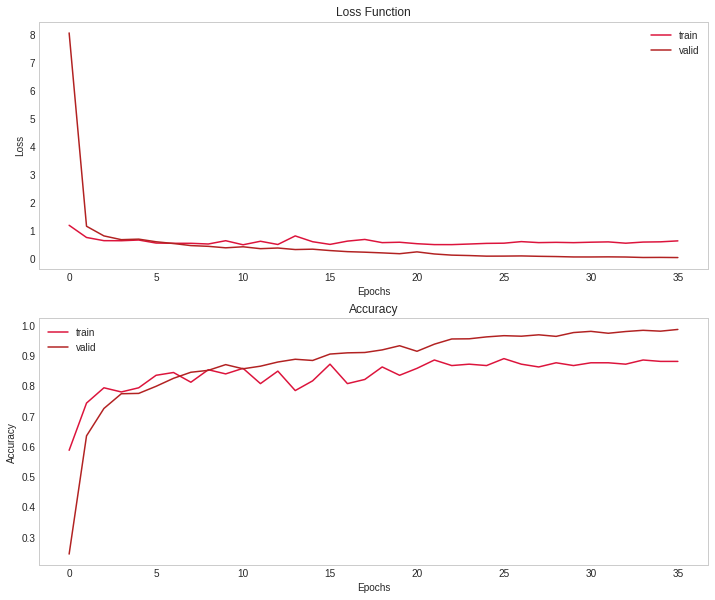

219/219 [==============================] - 0s 368us/step
Accuracy: 84.47%


[0.478106923299293, 0.8447488573588193]

In [24]:
history_plot(history)
inceptionresnetv2_model.load_weights(fw)
inceptionresnetv2_scores=inceptionresnetv2_model.evaluate(x_test_bn,y_test3)
print("Accuracy: %.2f%%"%(inceptionresnetv2_scores[1]*100))
inceptionresnetv2_scores